In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os                        

from scipy.interpolate import interpn
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

from math import sqrt, atan, log, exp, sin, cos, tan

from simulation_231217 import *

from pandas import ExcelWriter

import warnings
warnings.filterwarnings('ignore')

In [2]:
# environment settings: 
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',50)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)
pd.set_option('display.chop_threshold', 0.001)

np.core.arrayprint.set_printoptions(linewidth= 180)
np.set_printoptions(threshold=np.inf)

# Project name

In [3]:
project = "AGC"

**weather**    
-1 : a cold wave example (1 month)   
+1 : a hot wave (1 month)   

**weather and month**  
 weather = 0 and month = 0       : a year    
 weather = 0 and month = 1 to 12 : a month    

# General data

In [4]:
weather = 0
month   = 0

# Latitude of the location of analysis (and of weather data)
phi_deg = 50.90  
# Longitude
lambda_deg = -4.34067

t_set_heating  = 20
t_set_min      = 15

t_set_cooling  = 26 
t_set_max      = 30

E_lux   = 450
DLF     = 0.044 

n_50    = 0.77
e_leak  = 0.05 
rho_env = 0.2 # Building environment reflexion factor (-)

U_wd  = 1.35 #[W/m2/K]
f_fr  = 0.10 # Frame fraction
f_LT  = 0.81 # Luminous transmission factor (-)
g_gl  = 0.63 # Glazing solar factor (-)
g_bl  = 0.51 # Blind solar factor (-)

h_c   = 3 #[W/m2/K]
epsilon_ir = 0.9

time_step = 600
h_restart_rad = 9 # Number of system working hours of the radiant system preceeding the start of the convective system

CO2_vent_control  = True # Fresh air supply controlled by CO2 probe
OCC_light_control = True # Lighting controled by occupancy detector

# Occupancy profile

In [5]:
office     = (0, 0, 0, 0, 0, 0, 0, 0.5 , 0.9, 0.9, 0.9, 0.7, 0.5, 0.5 , 0.7, 0.7,  0.5, 0.3, 0, 0, 0, 0, 0, 0)
conference = (0, 0, 0, 0, 0, 0, 0, 0.15,   1,   1, 0.15,  0,   0, 0.15,   1,   1, 0.15,   0, 0, 0, 0, 0, 0, 0)


##### Zone,
# Occupancy profile
# Number of occupants
# Radiative heat gain per occupant (W/occ), Convective heat gain per occupant (W/occ), 
# Appliance heat gain per occupant (W/occ)
# Radiative heat gain from lighting (W/m²), Convective heat gain from lighting (W/m²)
# Installed heating power           (W/m²), Installed cooling power            (W/m²)

occupancy = \
[('office_S', office, 60, 60, 30, 100, 3, 3, 62, 80),
 ('office_N', office, 60, 60, 30, 100, 3, 3, 62, 80),
 ('office_M', office, 60, 60, 30, 100, 3, 3, 62, 80)
]

# HVAC system operation

In [6]:
hourly = \
[('office_S',   (0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) ),
 ('office_N',   (0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) ),
 ('office_M',   (0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) )
]

daily = \
[('office_S',   (1, 1, 1, 1, 1, 0, 0) ),
 ('office_N',   (1, 1, 1, 1, 1, 0, 0) ),
 ('office_M',   (1, 1, 1, 1, 1, 0, 0) )
]

# Ventilation data

In [7]:
##### Zone,
# number of floors, total floor area, internal volume, 
# fan supply air flow (m³/h), fan extracted air flow (m³/h), 
# efficiency of heat recovery, free-cooling air change rate (1/h)

q_occ_m3h = 30 # Fresh air flow per occupant
A_occ_m2  = 10 # Floor area per occupant
A_floor   = 52.5 * 11.5

q_a_m3h = A_floor/A_occ_m2 * q_occ_m3h

vent = \
[('office_S', 1, A_floor, A_floor*3, q_a_m3h, q_a_m3h, 0.75, 3),
 ('office_N', 1, A_floor, A_floor*3, q_a_m3h, q_a_m3h, 0.75, 3),
 ('office_M', 1, A_floor, A_floor*3, q_a_m3h, q_a_m3h, 0.75, 3)
]

# Wall types data

In [8]:
print('materials :')
materials.material.to_list()

materials :


['concrete_bloc_19cm',
 'concrete_bloc_14cm',
 'insulation',
 'reinforced_concrete',
 'concrete',
 'brick',
 'screed',
 'foamglass',
 'wood',
 'glass',
 'Air_layer_60mm',
 'Air_layer_275mm',
 'Waterproof_membrane',
 'Gravels']

In [9]:
# TYPES : floor, ceilng, wall_ext, wall_uncond, wall_cond
# From indoor to outdoor

walls_types = \
[('floor', 0, 0.025, 'wood'),
 ('floor', 1, 0.275, 'Air_layer_275mm'),
 ('floor', 2, 0.300, 'concrete'),
 
 ('wall_ext', 0, 0.036, 'wood'),
 ('wall_ext', 1, 0.150, 'insulation'),
 ('wall_ext', 2, 0.060, 'Air_layer_60mm'),
 ('wall_ext', 3, 0.014, 'glass'),   # 4 mm glazing + 1 cm Blinds
 
 ('wall_cond', 0, 0.018, 'wood'),
 ('wall_cond', 1, 0.054, 'insulation'),
 ('wall_cond', 2, 0.018, 'wood'),
 
 ('wall_uncond', 0, 0.018, 'wood'),
 ('wall_uncond', 1, 0.054, 'insulation'),
 ('wall_uncond', 2, 0.018, 'wood'),
 
 ('ceiling', 0, 0.300, 'reinforced_concrete'),
 ('ceiling', 1, 0.200, 'insulation'),
 ('ceiling', 2, 0.005, 'Waterproof_membrane'), 
 ('ceiling', 3, 0.050, 'Gravels')
]

# List of external walls (one face exposed to the sun radiation and to the infrared heat losses)
EXTwalls = ['ceiling', 'wall_ext']

# List of internal walls in contact with a conditioned zone
CONDwalls = ['floor', 'wall_cond']

# Wall dimensions and radiative emission

In [10]:
print('wall_types :')
list(set([i[0] for i in walls_types]))

wall_types :


['wall_cond', 'ceiling', 'wall_ext', 'floor', 'wall_uncond']

In [11]:
# Zone, azimuth, slope, wall_type, dimension 1, dimension 2, 
# Fraction of the zone heating power provided by the wall, 
# Fraction of the zone cooling power provided by the wall

walls = \
[('office_S',     0,  'floor',      52.5,   12,  0, 0),
 ('office_S',   180,  'wall_ext',     40,  3.8,  0, 0),
 ('office_S',   -90,  'wall_ext',     12,  3.8,  0, 0),
 ('office_S',     0,  'wall_ext',   52.5,  3.8,  0, 0),
 ('office_S',    90,  'wall_cond',    12,  3.0,  0, 0),
 ('office_S',   180,  'wall_cond',    12,  3.0,  0, 0),
 ('office_S',     0,  'ceiling',    52.5,   12,  0, 0.25),
 
 ('office_M',     0,  'floor',       52.5,   12,  0, 0),
 ('office_M',   180,  'wall_ext',      40,  3.8,  0, 0),
 ('office_M',   -90,  'wall_ext',      12,  3.8,  0, 0),
 ('office_M',     0,  'wall_ext',      40,  3.8,  0, 0),
 ('office_M',     0,  'wall_cond',     12,  3.0,  0, 0),
 ('office_M',    90,  'wall_cond',     12,  3.0,  0, 0),
 ('office_M',   180,  'wall_cond',     12,  3.0,  0, 0),
 ('office_M',     0,  'ceiling',     52.5,   12,  0, 0.25),
 
 ('office_N',     0,  'floor',        52.5,   12,  0, 0),
 ('office_N',   180,  'wall_ext',     52.5,  3.8,  0, 0),
 ('office_N',   -90,  'wall_ext',       12,  3.8,  0, 0),
 ('office_N',     0,  'wall_ext',       40,  3.8,  0, 0),
 ('office_N',     0,  'wall_cond',      12,  3.0,  0, 0),
 ('office_N',    90,  'wall_cond',      12,  3.0,  0, 0),
 ('office_N',     0,  'ceiling',      52.5,   12,  0, 0.25)
] 

In [12]:
# Zone, azimuth, number of identical windows, breadth, height
# Side screens angle (deg), Top screen angle (deg)
# Angle of front screen (deg), ratio of the screen distance to the window height

windows = \
[('office_S',   0,  35, 1.50, 2.20,   0,  0,  0,  0),
 ('office_S', -90,   8, 1.50, 2.20,   0,  0,  0,  0),
 ('office_S', 180,  28, 1.50, 2.20,   8,  8, 10, 12),
 
 ('office_M',   0,  28, 1.50, 2.20,   8,  8, 10, 12),
 ('office_M', -90,   8, 1.50, 2.20,   0,  0,  0,  0),
 ('office_M', 180,  28, 1.50, 2.20,   8,  8, 10, 12),
 
 ('office_N', 180,  35, 1.50, 2.20,   0,  0,  0,  0),
 ('office_N', -90,   8, 1.50, 2.20,   0,  0,  0,  0),
 ('office_N',   0,  28, 1.50, 2.20,   8,  8, 10, 12)
]

# Data Preprocessing

In [13]:
# Weather data

w = prepro_w(weather, month, phi_deg, lambda_deg)

h_out = w['h_out'].mean()


# Solar gains and IR losses

wd, Qwdsol, Qwdir, Itwd, Ibwd    = prepro_wd(windows, f_fr, f_LT, g_gl, g_bl, rho_env, epsilon_ir, w, hourly)
wl, fh_rad_z, fc_rad_z, Qwlsolir = prepro_wl(walls, rho_env, epsilon_ir, EXTwalls, w, wd, hourly)


# Profiles of occupancy, internal heat gains, set points, ventilation air flows, available heating/cooling powers

dfh, dfd, dfo, dfv, dfQM = prepro_occ_data(w, hourly, daily, occupancy, vent, e_leak, n_50)

hbh_profiles = \
    prepro_hbh_profile(w, dfh, dfd, dfo, dfQM, OCC_light_control, t_set_heating, t_set_min, t_set_cooling, t_set_max)
sbs_profiles = \
    prepro_sbs_profile(w, dfh, dfd, dfo, dfQM, dfv, fh_rad_z, fc_rad_z, CO2_vent_control, h_restart_rad, time_step)


# Wall parameters

wl = wall_parameters(walls_types, walls, wl, wd, n_50, U_wd, h_c, h_out, EXTwalls, CONDwalls)


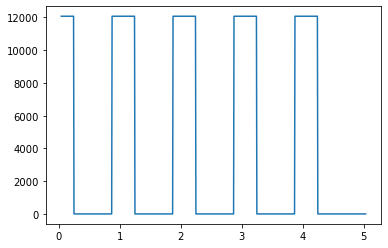

In [14]:
dd = sbs_profiles['office_S']
plt.plot(dd['hour_yr'].values[0:24*5*6]/24, dd['Qcr'].values[0:24*5*6])

# Simulation

In [15]:
%%time

zname_list, dfr_list = simulation(w, dfh, dfd, dfo, dfv, wl, weather, t_set_heating, t_set_cooling, \
               Qwdsol, Qwdir, Itwd, Ibwd, Qwlsolir, \
               hbh_profiles, sbs_profiles, \
               h_c, epsilon_ir, n_50, e_leak, E_lux, DLF, g_bl, \
               EXTwalls, CONDwalls, time_step)

with ExcelWriter(project+".xlsx") as writer:
        for n, dfi in enumerate(dfr_list):
            zonename = zname_list[n]
            dfi.to_excel(writer, sheet_name = zonename)

print('results for zones : ', zname_list)

results for zones :  ['office_S', 'office_N', 'office_M']
Wall time: 5min 47s


# Graphs

In [16]:
zone = 'office_S'

num_zone = zname_list.index(zone)
dfr = dfr_list[num_zone]
dfr[['Vv_m3', 'Qh_kWhm2', 'Qc_kWhm2', 'Ql_kWhm2', 'Qs_kWhm2', 'Qf_kWhm2', 'fr_overcool', 'fr_overheat']].tail(1).round(2)

,Vv_m3,Qh_kWhm2,Qc_kWhm2,Ql_kWhm2,Qs_kWhm2,Qf_kWhm2,fr_overcool,fr_overheat
52559,15663246.31,9.59,0.02,3.17,54.11,1.67,0.0,0.0


In [17]:
dfr.columns

Index(['hour_yr', 'day', 't_ext', 't_in', 'f_occ', 'q_m3h', 'Qh_Wm2', 'Qc_Wm2',
       'Ql_Wm2', 'Qs_Wm2', 'Qf_Wm2', 'overcool', 'overheat', 'Vv_m3',
       'Qh_kWhm2', 'Qc_kWhm2', 'Ql_kWhm2', 'Qs_kWhm2', 'Qf_kWhm2',
       'fr_overcool', 'fr_overheat'],
      dtype='object')

### Energy 

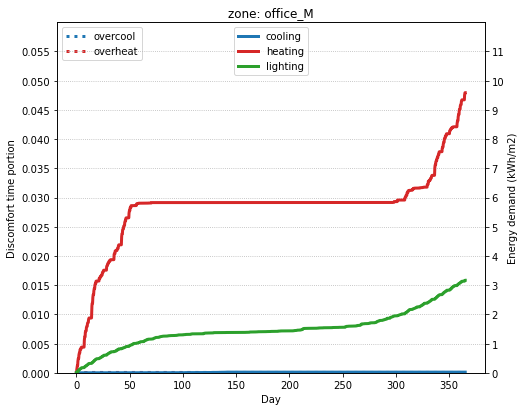

In [18]:
# pmax = 0.20
# Emax = 40
# pmax = 0.10
# Emax = 20
pmax = 0.05 
Emax = 10 

fig, ax1 = plt.subplots(figsize=(7.4, 5.6))

day = dfr.hour_yr/24

ax1.set_xlabel('Day')

ax1.set_ylabel('Discomfort time portion', color='k')
ax1.plot(day, dfr.fr_overcool, color='tab:blue', linestyle='dotted', linewidth = 3, label = 'overcool')
ax1.plot(day, dfr.fr_overheat, color='tab:red' , linestyle='dotted', linewidth = 3, label = 'overheat')

ax1.set_ylim(0, pmax + 0.01)
ax1.set_yticks(np.arange(0, pmax + 0.01, step = pmax/10))
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  

ax2.set_ylabel('Energy demand (kWh/m2)', color='k')  # we already handled the x-label with ax1
ax2.plot(day, dfr.Qc_kWhm2, color='tab:blue', linewidth = 3, label = 'cooling')
ax2.plot(day, dfr.Qh_kWhm2, color='tab:red',  linewidth = 3, label = 'heating')
ax2.plot(day, dfr.Ql_kWhm2, color='tab:green', linewidth = 3, label = 'lighting')

ax2.set_ylim(0, Emax + 2)
ax2.set_yticks(np.arange(0, Emax + 2, step = Emax/10))
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper center')

fig.tight_layout()  
plt.title('zone: ' + zonename)
plt.grid(linestyle ='dotted')
plt.show()

### Power

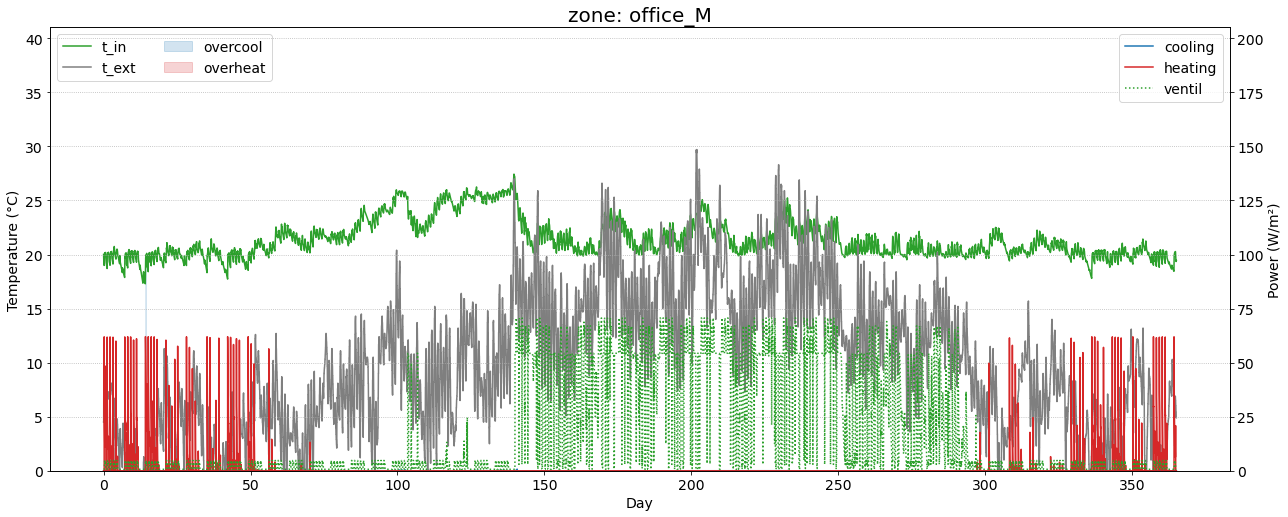

In [21]:
if weather == -1 :
    Q_min = -100
    Q_max =  201
    T_min = -20
    T_max =  41
else :
    Q_min = 0
    Q_max = 201
    T_min = 0
    T_max = 41

fig, ax1 = plt.subplots(figsize = (18,7))

day = dfr.hour_yr/24

ax1.set_xlabel('Day', fontsize = 14)
ax1.set_ylabel('Temperature (°C)', color='k', fontsize = 14)
ax1.fill_between(day, dfr.overcool * dfr.t_in, color='tab:blue', alpha = 0.2, label = 'overcool')
ax1.fill_between(day, dfr.overheat * dfr.t_in, color='tab:red',  alpha = 0.2, label = 'overheat')
ax1.plot(day, dfr.t_in,  color='tab:green', label = 't_in')
ax1.plot(day, dfr.t_ext, color='tab:gray',  label = 't_ext')

ax1.set_ylim(T_min, T_max)
ax1.set_yticks(np.arange(T_min, T_max, step = 5))
ax1.tick_params(axis='y', labelcolor='k', labelsize=14)
ax1.legend(ncol=2, fontsize=14, loc='upper left')

# ax1.set_xlim(150, 160)

ax1.tick_params(axis='x', labelcolor='k', labelsize=14)
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Power (W/m²)', color='k', fontsize = 14)
ax2.plot(day, dfr.Qc_Wm2, color='tab:blue', label = 'cooling')
ax2.plot(day, dfr.Qh_Wm2, color='tab:red',  label = 'heating')
# ax2.plot(day, dfr.Qs_Wm2, color='tab:orange',  linestyle = 'dotted',  label = 'solar')
# ax2.plot(day, dfr.Qf_Wm2, color='tab:blue', linestyle = 'dotted', label = 'ceiling')
ax2.plot(day, dfr.q_m3h/100, color='tab:green', linestyle = 'dotted', label = 'ventil')

ax2.set_ylim(Q_min, Q_max + 4)
ax2.set_yticks(np.arange(Q_min, Q_max, step = 25))
ax2.tick_params(axis='y', labelcolor='k', labelsize=14)
ax2.legend(fontsize=14, loc='upper right')

fig.tight_layout()
plt.grid(linestyle='dotted')
plt.title('zone: ' + zonename, fontdict = {'fontsize' : 20})
plt.grid(linestyle ='dotted')
plt.show()